# 🎤 Artists Popularity
By *Artur Gomes Simão*

This notebook uses the Kaggle dataset 'Music artists popularity' (https://www.kaggle.com/datasets/pieca111/music-artists-popularity), to estimate the number of listeners of an artist, using different AI strategies and methods.

## First Steps

Importing Libraries

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

Loading the dataset

In [178]:
popularity = pd.read_csv('artist_popularity/artists.csv')
popularity.head()

C:\Users\artur\AppData\Local\Temp\ipykernel_14544\369110390.py:1: DtypeWarning: Columns (2,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  popularity = pd.read_csv('artist_popularity/artists.csv')


,mbid,artist_mb,artist_lastfm,country_mb,country_lastfm,tags_mb,tags_lastfm,listeners_lastfm,scrobbles_lastfm,ambiguous_artist
0,cc197bad-dc9c-440d-a5b5-d52ba2e14234,Coldplay,Coldplay,United Kingdom,United Kingdom,rock; pop; alternative rock; british; uk; brit...,rock; alternative; britpop; alternative rock; ...,5381567,360111850,False
1,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,Radiohead,United Kingdom,United Kingdom,rock; electronic; alternative rock; british; g...,alternative; alternative rock; rock; indie; el...,4732528,499548797,False
2,8bfac288-ccc5-448d-9573-c33ea2aa5c30,Red Hot Chili Peppers,Red Hot Chili Peppers,United States,United States,rock; alternative rock; 80s; 90s; rap; metal; ...,rock; alternative rock; alternative; Funk Rock...,4620835,293784041,False
3,73e5e69d-3554-40d8-8516-00cb38737a1c,Rihanna,Rihanna,United States,Barbados; United States,pop; dance; hip hop; reggae; contemporary r b;...,pop; rnb; female vocalists; dance; Hip-Hop; Ri...,4558193,199248986,False
4,b95ce3ff-3d05-4e87-9e01-c97b66af13d4,Eminem,Eminem,United States,United States,turkish; rap; american; hip-hop; hip hop; hiph...,rap; Hip-Hop; Eminem; hip hop; pop; american; ...,4517997,199507511,False


In [179]:
popularity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466083 entries, 0 to 1466082
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   mbid              1466083 non-null  object 
 1   artist_mb         1466070 non-null  object 
 2   artist_lastfm     986755 non-null   object 
 3   country_mb        662368 non-null   object 
 4   country_lastfm    211498 non-null   object 
 5   tags_mb           119946 non-null   object 
 6   tags_lastfm       381075 non-null   object 
 7   listeners_lastfm  986760 non-null   float64
 8   scrobbles_lastfm  986760 non-null   float64
 9   ambiguous_artist  1466083 non-null  bool   
dtypes: bool(1), float64(2), object(7)
memory usage: 102.1+ MB


Now that we know the number of data points and the types of data, we need to convert them in a way that artificial intelligence can use them.


To do this, we will transform the parameters 'ambiguous_artist' and 'country_lastfm' into floats.

In [180]:
from sklearn.preprocessing import LabelEncoder

popularity['ambiguous_artist'] = popularity['ambiguous_artist'].astype(int).astype(float)

country_map = {
    'Unknown': 0.0,
    'United States': 1.0,
    'United Kingdom': 2.0,
    'Germany': 3.0,
    'Japan': 4.0,
    'France': 5.0,
}

default_value = 0.0
popularity['country_lastfm'] = (
    popularity['country_lastfm']
    .fillna('Unknown')
    .astype(str)
    .str.strip()
    .str.title()
    .apply(lambda x: country_map.get(x, default_value))
    .astype(int)
)

The 'features' parameter will represent the main characteristics for determining the artist's number of listeners.


In [181]:
features = [
    'country_lastfm',
    'scrobbles_lastfm',
    'ambiguous_artist'
]

Additionally, there are some columns with null data. Therefore, we will ignore this missing information.


In [182]:
popularity = popularity.dropna(subset=features)

## Exploratory Analisys

In the following graphs, we can get an idea of ​​how the chosen features influence the popularity of an artist.


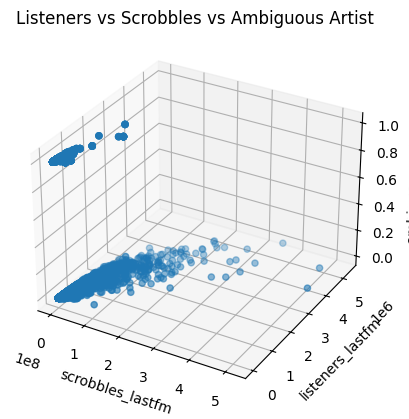

In [183]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter 3D
ax.scatter(
    popularity['scrobbles_lastfm'], 
    popularity['listeners_lastfm'], 
    popularity['ambiguous_artist']
)

# Labels
ax.set_xlabel('scrobbles_lastfm')
ax.set_ylabel('listeners_lastfm')
ax.set_zlabel('ambiguous_artist')

plt.title('Listeners vs Scrobbles vs Ambiguous Artist')
plt.show()


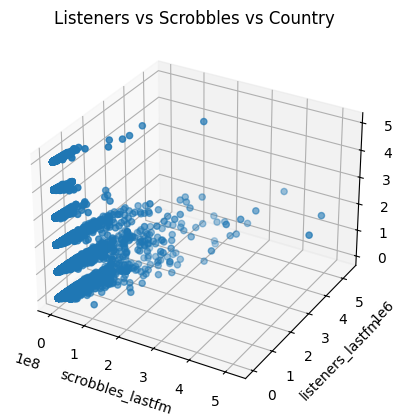

In [184]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter 3D
ax.scatter(
    popularity['scrobbles_lastfm'], 
    popularity['listeners_lastfm'], 
    popularity['country_lastfm']
)

# Labels
ax.set_xlabel('scrobbles_lastfm')
ax.set_ylabel('listeners_lastfm')
ax.set_zlabel('country_lastfm')

plt.title('Listeners vs Scrobbles vs Country')
plt.show()

From these graphs, we can analyze that the number of listeners has a fairly linear relationship with the number of scrobbles, and the country and page sharing status on last.fm contribute somewhat to the numbers. It is also possible to notice the presence of outliers in the data.

The following histogram shows the distribution of listeners by artist.

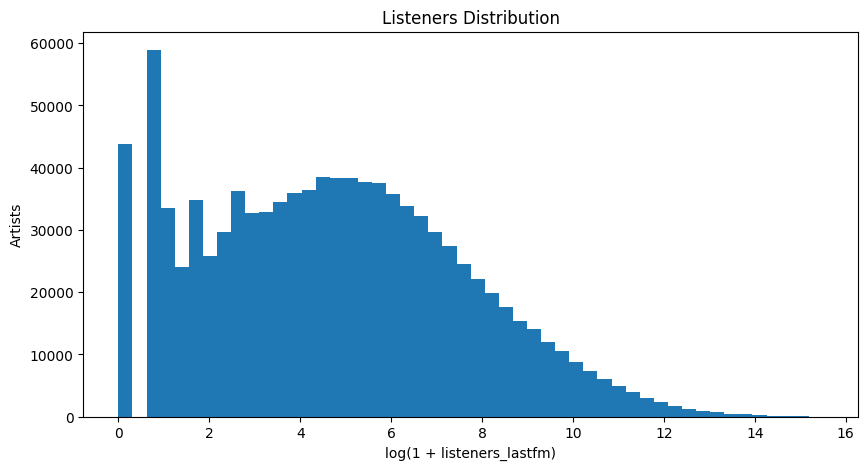

In [185]:
plt.figure(figsize=(10,5))
plt.hist(np.log1p(popularity['listeners_lastfm']), bins=50)
plt.xlabel('log(1 + listeners_lastfm)')
plt.ylabel('Artists')
plt.title('Listeners Distribution')
plt.show()

This histogram shows that the number of artists with a low number of listeners is very high, and decreases as the number of listeners increases.

## Pre-Processing

In the exploratory analysis, we can observe the presence of outliers in the data, which can hinder the training of artificial intelligence models. Therefore, corrections to the database are necessary.

Importing libraries for corrections:

In [186]:
from sklearn.model_selection import train_test_split
from scipy import stats

Another important thing to do is remove the outputs that are equal to 0, because otherwise the model metrics will have problems.


In [187]:
popularity_filtered = popularity[popularity['listeners_lastfm'] != 0].copy()

print(f"Original samples: {len(popularity)}")
print(f"Filtered samples: {len(popularity_filtered)}")

Original samples: 986760
Filtered samples: 942906


Before applying the filter, we need to define the input(x) and output(y) of the models.


In [188]:
x_val = popularity_filtered[features]
y_val = popularity_filtered['listeners_lastfm']

Now, to remove the outliers, we are going to use the IQR method:

In [189]:
Q1 = x_val.quantile(0.25)
Q3 = x_val.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = ~((x_val < lower_bound) | (x_val > upper_bound)).any(axis=1)
x_filtered = x_val[mask]
y_filtered = y_val[mask]

print(f"Number of original samples: {len(x_val)}")
print(f"Filtered samples: {len(x_filtered)}")
print(f"Samples removed: {len(x_val) - len(x_filtered)}")



Number of original samples: 942906
Filtered samples: 740605
Samples removed: 202301


Since the dataset is very large, we will also reduce the total number of samples so that the training time is shorter. Furthermore, a very interesting approach is to balance the number of listeners across groups, because, as seen previously, the distribution of listeners per artist does not have similar numbers (few artists have many listeners and many artists have few listeners).


In [190]:
temp = x_filtered.copy()
temp['listeners_lastfm'] = y_filtered

temp['listeners_log'] = np.log1p(temp['listeners_lastfm'])

N_BINS = 10
temp['popularity_bin'] = pd.cut(
    temp['listeners_log'], 
    bins=N_BINS, 
    labels=False, 
    include_lowest=True
)

samples_number = 10000
samples_per_bin = samples_number // N_BINS

x_y_sampled_stratified = (
    temp.groupby('popularity_bin')
    .sample(
        n=samples_per_bin,      
        replace=True,           
        random_state=999
    )
)

x_y_sampled_stratified = x_y_sampled_stratified.reset_index(drop=True)

x_sampled_stratified = x_y_sampled_stratified.drop(
    columns=['listeners_lastfm', 'listeners_log', 'popularity_bin']
)
y_sampled_stratified = x_y_sampled_stratified['listeners_lastfm']

x_sampled_final = x_sampled_stratified.sample(frac=1, random_state=999)
y_sampled_final = y_sampled_stratified.loc[x_sampled_final.index]

By using this binning technique, we were able to better balance artist samples by number of listeners (in other words, the number of artists with few listeners became similar to the number of artists with many listeners). After that, we need to split the dataset into training (80%) and testing (20%) sets:


In [191]:

x_train, x_test, y_train, y_test = train_test_split(
    x_sampled_final, y_sampled_final,
    test_size=0.2,
    random_state=999,
)

With this steps, we can begin training the models.


## Linear Regretion

Importing libraries:

In [192]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

To apply the model, we need to normalize the data and then apply logistic regression. Note that the maximum number of iterations used was 5000 to allow the model time to learn, and the 'saga' parameter was used because it is efficient with large databases.
:


In [193]:
lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)

print(f'R²:{r2_score(y_test, y_pred_lr):.4f}')

R²:0.7707


This shows that R-squared using linear regression is 0.77. The next script will verify the other metrics:

In [194]:
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mape_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100

print(f"MAE : {mae_lr:.4f}")
print(f"MAPE: {mape_lr:.2f}%")
print(f"MSE : {mse_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")

MAE : 389.2162
MAPE: 581.02%
MSE : 524904.7176
RMSE: 724.5031


With these metrics (MAE = 389.21 | MAPE = 581.02% | MSE = 524904.7176 | RMSE = 724.5031) we can conclude that the linear regression model, while very good, is not yet perfect. This is because the data are not 100% linear and contain some variations.

## Decision Tree

Importing libraries:

In [195]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Training model with 'squared-error' parameter and 'max_depth=5' to avoid overfitting:

In [196]:
dt = DecisionTreeRegressor(criterion='squared_error', max_depth=5, random_state=999)
dt.fit(x_train, y_train)
y_pred_dt = dt.predict(x_test)

print(f'R²:{r2_score(y_test, y_pred_dt):.4f}')

R²:0.7574


This shows that the decision tree model has a r-squared of 0.75. Now, let's see the metrics.

In [197]:
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mape_dt = np.mean(np.abs((y_test - y_pred_dt) / y_test)) * 100

print(f"MAE : {mae_dt:.4f}")
print(f"MAPE: {mape_dt:.2f}%")
print(f"MSE : {mse_dt:.4f}")
print(f"RMSE: {rmse_dt:.4f}")

MAE : 369.0289
MAPE: 156.65%
MSE : 555290.6001
RMSE: 745.1782


With these metrics (MAE = 369.02 | MAPE = 156.65% | MSE = 555290.60 | RMSE = 745.17), we can conclude that the decision tree model is slightly worse than linear regression, but has a much lower percentage of estimation error. This may have happened because the tree model is quite sensitive to noise, sometimes generating flawed generalizations.

## SVM

Importing libraries:

In [198]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

For this model, we are going to use the 'linear' and 'C=10' parameters. The 'linear' parameter is better in this case because, in a way, the data has a somewhat linear structure:


In [199]:
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='linear', C=10, gamma='scale'))
])

svm_model.fit(x_train, y_train)

y_pred_svm = svm_model.predict(x_test)

print(f'R²:{r2_score(y_test, y_pred_svm):.4f}')

R²:0.7694


Now for the other metrics:

In [200]:
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)
mape_svm = np.mean(np.abs((y_test - y_pred_svm) / y_test)) * 100

print(f"MAE : {mae_svm:.4f}")
print(f"MAPE: {mape_svm:.2f}%")
print(f"MSE : {mse_svm:.4f}")
print(f"RMSE: {rmse_svm:.4f}")

MAE : 375.7387
MAPE: 122.83%
MSE : 527712.9414
RMSE: 726.4385


With the metrics (MAE = 375.73 | MAPE = 122.83% | MSE = 527712.94 | RMSE = 726.43) it is noticeable that the MAPE of this model was the best so far, in addition to having its other metrics with a very satisfactory value. One of the possible reasons for this achievement is the model's robustness against overfitting and overgeneralization.



## MLP

Importing libraries:

In [201]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

To train this model, we first normalized the data and then performed the training. In this case, we used 2 layers of neurons (200, 100) and 1000 iterations.


In [202]:
mlp_model = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(200, 100), 
                        activation='relu', 
                        solver='adam', 
                        max_iter=1000, 
                        random_state=999, 
                        early_stopping=True))
])

mlp_model.fit(x_train, y_train)

y_pred_mlp = mlp_model.predict(x_test)

print(f'R²:{r2_score(y_test, y_pred_mlp):.4f}')


R²:0.7748


Checking the other metrics:

In [203]:
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mse_mlp)
mape_mlp = np.mean(np.abs((y_test - y_pred_mlp) / y_test)) * 100

print(f"MAE : {mae_mlp:.4f}")
print(f"MAPE: {mape_mlp:.2f}%")
print(f"MSE : {mse_mlp:.4f}")
print(f"RMSE: {rmse_mlp:.4f}")

MAE : 363.1570
MAPE: 147.97%
MSE : 515400.0800
RMSE: 717.9137


This metrics (MAE = 363.15 | MAPE = 147.97% | MSE = 515400.08 | RMSE = 717.91) show that the neural model was the best overall. Its metrics are quite acceptable, and the R-squared was the best of all models. Although the database has some linearity, it is not perfect, and this is where the MLP model comes in due to its great capacity for generalization in complex data.






## Conclusions

The problem of estimating an artist's audience based on some statistical information proved more complex than expected. Although the data appeared somewhat linear, we noted that it is not actually as perfect as it seemed. Based on the analyses, the MLP model was the best evaluated, with very good metrics and the best R-squared (0.77). The other models also had very satisfactory results, especially the linear regression model, which, despite being simpler, still excelled in some aspects.

Another very important point to highlight was the need for robust data filtering. Removing outliers, null data, and especially balancing samples, proved essential for good model training.

Moving on to an analysis of the results of the best model (MLP), a graph was plotted below showing the model's errors and successes on the test set:


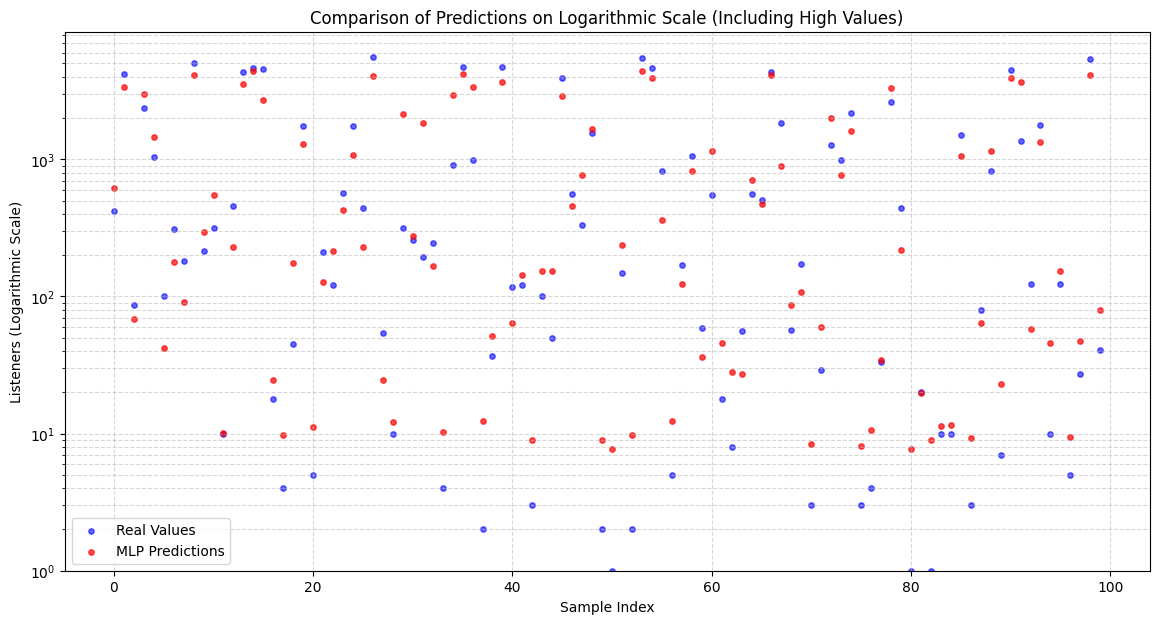

In [204]:
N_SAMPLES = 100 

y_test_plot = y_test[:N_SAMPLES]
y_pred_mlp_plot = y_pred_mlp[:N_SAMPLES]

if isinstance(y_test_plot, pd.Series):
    y_test_plot = y_test_plot.values

plt.figure(figsize=(14, 7))

plt.scatter(range(N_SAMPLES), y_test_plot, color='blue', label='Real Values', alpha=0.6, s=15)

plt.scatter(range(N_SAMPLES), y_pred_mlp_plot, color='red', label='MLP Predictions', alpha=0.7, s=15)

plt.yscale('log')

plt.title('Comparison of Predictions on Logarithmic Scale (Including High Values)')
plt.xlabel('Sample Index')
plt.ylabel('Listeners (Logarithmic Scale)')
plt.legend()
plt.grid(True, which="both", linestyle='--', alpha=0.5)

plt.ylim(ymin=1) 

plt.show()

This graph was created from 100 data samples, and a logarithmic scale was used to better distribute the number of artists with high and low recognition. Based on this, it is possible to note that the real and estimated values ​​are, in most cases, close when considering their scale.

To further verify the results, some artists will be added to the database below, and the model will then estimate the number of listeners based on the information provided (based on information from the website last.fm).
- Frank Ocean: 4.1M listeners
- TV Girl: 2.7M listeners
- Playboi Carti: 2.3M listeners
- Alee: 115.1K listeners
- Patrick Cc: 85.1K listeners


In [205]:
from sklearn.preprocessing import LabelEncoder

new_artist = pd.DataFrame([
    {
        # Frank Ocean
        'country_lastfm': 'United States',  
        'scrobbles_lastfm': 726400000.0,
        'ambiguous_artist': 0.0
    },
    {
        # TV Girl
        'country_lastfm': 'United States',  
        'scrobbles_lastfm': 262400000.0,
        'ambiguous_artist': 0.0
    },
    {
        # Playboi Carti
        'country_lastfm': 'United States',  
        'scrobbles_lastfm': 721200000.0,
        'ambiguous_artist': 0.0
    },
    {
        # Alee
        'country_lastfm': 'Brazil',  
        'scrobbles_lastfm': 14900000.0,
        'ambiguous_artist': 0.0
    },
    {
        # Patrick Cc:
        'country_lastfm': 'Unknown',  
        'scrobbles_lastfm': 1400000.0,
        'ambiguous_artist': 0.0
    }
], index=['Frank Ocean', 'TV Girl', 'Playboi Carti', 'Alee', 'Patrick Cc:'])

new_artist['ambiguous_artist'] = new_artist['ambiguous_artist'].astype(int).astype(float)

country_map = {
    'Unknown': 0.0,
    'United States': 1.0,
    'United Kingdom': 2.0,
    'Germany': 3.0,
    'Japan': 4.0,
    'France': 5.0,
}

default_value = 0.0
new_artist['country_lastfm'] = (
    new_artist['country_lastfm']
    .fillna('Unknown')
    .astype(str)
    .str.strip()
    .str.title()
    .apply(lambda x: country_map.get(x, default_value))
    .astype(int)
)

listeners_predict = mlp_model.predict(new_artist)

results = pd.DataFrame({
    'Artist': new_artist.index,
    'Listeners': listeners_predict,
})
pd.set_option('display.float_format', '{:.0f}'.format)

print(results)


          Artist  Listeners
0    Frank Ocean  205133530
1        TV Girl   74100889
2  Playboi Carti  203665060
3           Alee    4207401
4    Patrick Cc:     395029


From this test, it is possible to note that the model works better with artists with few listeners (who make up the vast majority of the dataset), but the results are quite plausible considering the scales and the fact that this problem requires many more variables.